In [1]:
#trying to figure out that lambda layer fix + scrambler update example 

import random 
import string
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores
from scipy import stats
from itertools import product 
import random

2021-12-06 21:50:56.437742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-06 21:50:58.128337: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 21:50:58.129822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-06 21:50:58.196653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 21:50:58.197526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:

In [2]:
import tensorflow 
print (tensorflow.__version__)

2.4.1


In [3]:
print (keras.__version__)

2.4.3


In [4]:
#making a random seq to random value predictor that takes in (N, 4) tensors 

In [5]:
#making random dna data 

def gen_random_dna(len_seqs, number_to_gen):
    nucleotides = ['A', 'T', 'G', 'C']
    return [''.join(random.choice(nucleotides) for i in range(len_seqs)) for j in range(0, number_to_gen)]

def dummy_function_to_learn(dna, mu = 0, sigma = 1, inc_up = 5, inc_down = 5, up_reg_motifs = ["AAACCC"], down_reg_motifs = ["TTTGGG"]):
    #just going to make a fakey relationship between motif counts and a dummy value (else assign background noise)
    random_val = np.random.normal(mu, sigma)
    #figure out how much to add/subtract from it based on the motifs given 
    up_counter = sum([dna.count(x) for x in up_reg_motifs])
    #print (up_counter)
    down_counter = sum([dna.count(x) for x in down_reg_motifs])
    #print (down_counter)
    #print (random_val)
    return random_val + (inc_up * up_counter) - (inc_down * down_counter)

In [6]:
def one_hot_encode(seqs):
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(seqs),len(seqs[0]),4])
    for i in range(0, len(seqs)): #
        seq = seqs[i] 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

In [7]:
def load_dna_data(train_data_path, test_data_path, col_seq, col_val):
    
    #Train data returns (N, 1, L, X) (n = seqs, 1 is dummy dim, L is seq length, X is 4 (DNA) or 20 (Protein)
    e_train = pd.read_csv(train_data_path)    
    seq_e_train = one_hot_encode(e_train,seq_len=50)
    x_train = seq_e_train
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
    y_train = np.array(e_train[col_val].values)
    y_train = np.reshape(y_train, (y_train.shape[0],1))

    #Test data
    e_test = pd.read_csv(test_data_path)
    seq_e_test = one_hot_encode(e_test, seq_len=50)
    x_test = seq_e_test
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
    y_test = np.array(e_test['scaled_rl'].values)
    y_test = np.reshape(y_test, (y_test.shape[0],1))

    print("x_train.shape = " + str(x_train.shape))
    print("x_test.shape = " + str(x_test.shape))

    print("y_train.shape = " + str(y_train.shape))
    print("y_test.shape = " + str(y_test.shape))
    
    return x_train, y_train, x_test, y_test

In [12]:
#all kmers of len 4 
nucleotides = ['A', 'T', 'G', 'C']
all_kmers  = [''.join(x) for x in product(nucleotides, repeat=4)]
random.shuffle(all_kmers)
#select some kmers to be up motifs and some ot be down motifs 
up_motifs = all_kmers[0:3]
print ('up motifs: ', up_motifs)
down_motifs = all_kmers[-3:]
print ('down motifs: ', down_motifs)

up motifs:  ['AACA', 'CCTA', 'CGGA']
down motifs:  ['GAAG', 'CCGC', 'CATT']


In [13]:
all_dna = gen_random_dna(50, 50000)
all_dna_y = np.array([dummy_function_to_learn(seq, up_reg_motifs = up_motifs, down_reg_motifs = down_motifs ) for seq in all_dna])

In [14]:
all_dna_encoded = one_hot_encode(all_dna)
print (all_dna_encoded.shape)

(50000, 50, 4)


In [15]:
#80/20 train/test split 
train_set_x = all_dna_encoded[0:40000]
np.save('x_train_rand_model2.npy', train_set_x)
train_set_y = all_dna_y[0:40000]
np.save('y_train_rand_model2.npy', train_set_x)
#val 
val_set_x = all_dna_encoded[40000:45000]
np.save('x_val_rand_model2.npy', val_set_x)
val_set_y = all_dna_y[40000:45000]
np.save('y_val_rand_model2.npy', val_set_y)
#test
test_set_x = all_dna_encoded[45000:]
np.save('x_test_rand_model2.npy', test_set_x)
test_set_y = all_dna_y[45000:]
np.save('y_test_rand_model2.npy', test_set_y)

/home/ubuntu/anaconda3/envs/test_gpu_2/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


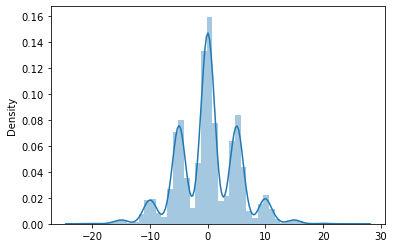

In [16]:
#look at distribution 
sns.distplot(all_dna_y)
None

In [20]:
#simple CNN model (1 CNN layer, 1 dense)
model = Sequential()
model.add(Conv1D(activation="relu", input_shape=(50, 4), padding='same', filters=120, kernel_size=6))
#model.add(Dropout(0.1))
model.add(Conv1D(activation="relu", input_shape=(50, 1), padding='same', filters=120, kernel_size=8))
#model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=adam)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 50, 120)           3000      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 120)           115320    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               720120    
_________________________________________________________________
activation_2 (Activation)    (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
callbacks =[EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto')]
model.fit(x = train_set_x, y = train_set_y, batch_size=128, epochs=20, verbose=1, callbacks = callbacks, validation_data = (val_set_x, val_set_y), shuffle = True)

Epoch 1/20
313/313 [==============================] - 3s 8ms/step - loss: 24.7019 - val_loss: 5.0628
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 3.5570 - val_loss: 1.7431
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 1.6947 - val_loss: 1.4706
Epoch 4/20
313/313 [==============================] - 2s 7ms/step - loss: 1.4670 - val_loss: 1.3726
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 1.3517 - val_loss: 1.4087
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 1.2960 - val_loss: 1.3025
Epoch 7/20
313/313 [==============================] - 2s 7ms/step - loss: 1.1611 - val_loss: 1.3085
Epoch 8/20
313/313 [==============================] - 2s 7ms/step - loss: 1.1468 - val_loss: 1.2940
Epoch 9/20
313/313 [==============================] - 2s 7ms/step - loss: 1.0550 - val_loss: 1.3260
Epoch 00009: early stopping


In [23]:
model.save('random_dna_model2.hdf5')

/home/ubuntu/anaconda3/envs/test_gpu_2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LinregressResult(slope=1.0083575832048475, intercept=0.1889666913125975, rvalue=0.9858385201254246, pvalue=0.0, stderr=0.0008576615334389848, intercept_stderr=0.004400934200021218)


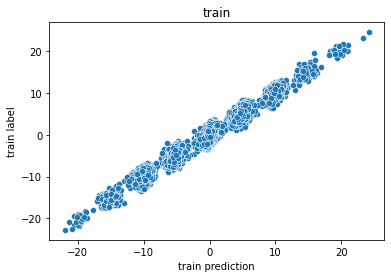

In [24]:
train_preds = model.predict(train_set_x).reshape(-1)
sns.scatterplot(train_preds, train_set_y)
plt.xlabel('train prediction')
plt.ylabel('train label')
plt.title('train')
print (stats.linregress(train_preds, train_set_y))

LinregressResult(slope=0.9957821566240018, intercept=0.21841259752853176, rvalue=0.976140236808861, pvalue=0.0, stderr=0.00313325646271664, intercept_stderr=0.015962872377164903)


/home/ubuntu/anaconda3/envs/test_gpu_2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


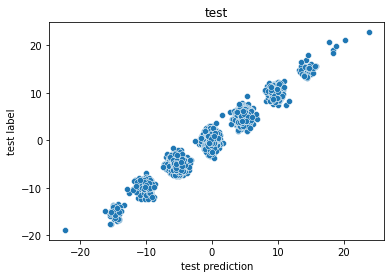

In [25]:
test_preds = model.predict(test_set_x).reshape(-1)
sns.scatterplot(test_preds, test_set_y)
plt.xlabel('test prediction')
plt.ylabel('test label')
plt.title('test')
print (stats.linregress(test_preds, test_set_y))

In [28]:
#load the data 
train_set_x = np.load('x_train_rand_model2.npy')
y_train = np.load('y_train_rand_model2.npy')
val_set_x = np.load('x_val_rand_model2.npy')
test_set_x = np.load('x_test_rand_model2.npy')
y_test = np.load('y_test_rand_model2.npy')

In [29]:
#fix model and apply scrambler 
#setting up a scrambling neural network 
#Problem: scramblers expect a input like: (N, 1, L, 4)
#But the original dataset is shaped (N,L,4)
#to fix this, add a lambda layer reshaping the input to the predictor 

#example: 
from keras.layers import Lambda

model = load_model('random_dna_model2.hdf5')
inp = Input(shape = (1, 50, 4))
lambda_fix = Lambda(lambda x: x[:, 0, :])(inp)
out = model(lambda_fix)
predictor_now = Model(inputs = inp, outputs = out)
print (predictor_now.summary())
predictor_now.save('random_dna_model_Fixed2.hdf5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 50, 4)]        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 50, 4)             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 838561    
Total params: 838,561
Trainable params: 838,561
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
#add dummy dimension to x values 
x_train = np.reshape(train_set_x, (train_set_x.shape[0], 1, train_set_x.shape[1], train_set_x.shape[2]))
x_val = np.reshape(val_set_x, (val_set_x.shape[0], 1, val_set_x.shape[1], val_set_x.shape[2]))
x_test = np.reshape(test_set_x, (test_set_x.shape[0], 1, test_set_x.shape[1], test_set_x.shape[2]))

In [31]:
#try to apply scrambler 
#Define sequence template and background
encoder = OneHotEncoder(seq_length=50, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})
sequence_template = '$' * 50
pseudo_count = 1.0
onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)


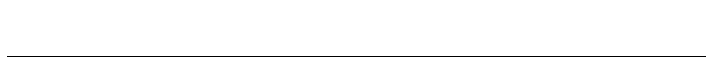

In [32]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(10, 1), logo_height=1.0, plot_start=0, plot_end=50)


In [33]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9999520889805593


In [44]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 4,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=50,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [45]:
x_train.shape
#just going to use the first 10K for training the scrambler 
subset_train_x = x_train[:5024]
subset_train_y = y_train[:5024]
#using first 1000 for test 
subset_test_x = x_test[:1024]
subset_test_y = y_test[:1024]

In [60]:
#Train scrambler

n_epochs = 10

train_history = scrambler.train(
    predictor_now,
    subset_train_x,
    subset_train_y,
    subset_test_x,
    subset_test_y,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.125,
    entropy_weight=5
)

#note that the MLIR optimization message is benign and is expected behavior as of tf 2.3 
#TODO: add in something to mute that message? 


Epoch 1/10
157/157 [==============================] - 40s 185ms/step - loss: 7.5800 - nll_loss: 4.4833 - entropy_loss: 3.0967 - val_loss: 8.9681 - val_nll_loss: 5.6102 - val_entropy_loss: 3.3578
Epoch 2/10
157/157 [==============================] - 14s 92ms/step - loss: 7.2652 - nll_loss: 4.3833 - entropy_loss: 2.8818 - val_loss: 8.7439 - val_nll_loss: 5.6158 - val_entropy_loss: 3.1281
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 6.9783 - nll_loss: 4.2646 - entropy_loss: 2.7137 - val_loss: 8.5865 - val_nll_loss: 5.8209 - val_entropy_loss: 2.7656
Epoch 4/10
157/157 [==============================] - 13s 80ms/step - loss: 6.9189 - nll_loss: 4.2763 - entropy_loss: 2.6425 - val_loss: 8.8665 - val_nll_loss: 6.6240 - val_entropy_loss: 2.2425
Epoch 5/10
157/157 [==============================] - 13s 80ms/step - loss: 6.6524 - nll_loss: 4.2761 - entropy_loss: 2.3762 - val_loss: 8.4256 - val_nll_loss: 5.8260 - val_entropy_loss: 2.5996
Epoch 6/10
157/157 [=========

In [61]:
#Save scrambler checkpoint
save_dir = 'saved_models_dummy_ex'

model_name = 'random_dna_model_example'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models_dummy_ex/random_dna_model_example.h5 


In [62]:
#Load models
save_dir = 'saved_models_dummy_ex'

model_name = 'random_dna_model_example'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models_dummy_ex/random_dna_model_example.h5 


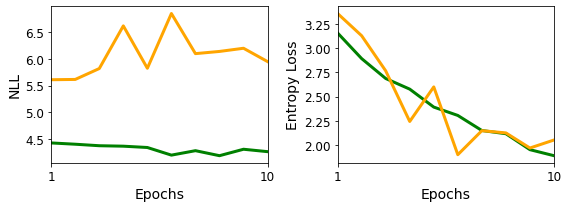

In [63]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [64]:
#Interpret the test set using the trained scrambler

pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)


157/157 [==============================] - 2s 13ms/step


Test sequence 0:
 - Prediction (original) = 0.47
 - Predictions (scrambled) = [-0.7, -0.5, -1.4, -1.2, -0.9, -0.8, -1.1, -0.5, 2.79, -0.1, -1.7, -3.0, -0.9, -0.4, -2.8, -0.2, -0.6, -0.9, -1.2, -3.6, -0.2, -0.8, -0.2, 1.34, 2.26, -1.1, -1.7, -0.5, 1.5, -1.8, -0.6, 0.14]
 - Pred scrambled mean(std):  -0.6678125 1.307738349152364
['AACA', 'CCTA', 'CGGA']
['GAAG', 'CCGC', 'CATT']


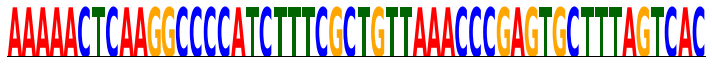

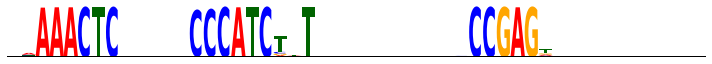

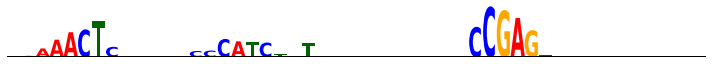

Test sequence 1:
 - Prediction (original) = 4.3
 - Predictions (scrambled) = [4.3, 4.28, 6.09, 2.29, 3.36, 3.7, 5.22, 4.51, -1.4, 5.44, 4.67, -0.5, 6.87, 4.11, 4.24, 3.77, 3.65, 3.87, 4.6, 8.57, 3.86, 4.56, 4.45, -2.0, 4.61, 4.73, -5.7, 3.32, 4.29, -0.2, 4.92, 4.54]
 - Pred scrambled mean(std):  3.5318750000000003 2.7112479109028373
['AACA', 'CCTA', 'CGGA']
['GAAG', 'CCGC', 'CATT']


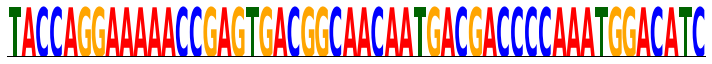

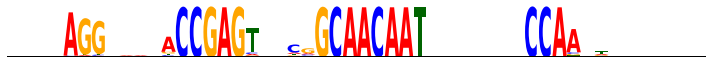

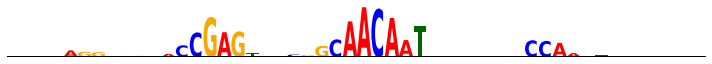

Test sequence 2:
 - Prediction (original) = 0.16
 - Predictions (scrambled) = [0.48, -0.8, 0.3, 0.5, -2.5, -0.1, 0.72, 0.18, 0.67, -0.1, -2.7, 0.16, 0.1, -0.1, -0.1, 0.39, 0.19, 0.29, -0.1, -1.1, 0.12, -0.5, 0.11, 0.4, 0.04, 0.45, 1.53, 0.21, 0.38, 2.53, 0.24, 0.13]
 - Pred scrambled mean(std):  0.06312499999999999 0.9157627882672456
['AACA', 'CCTA', 'CGGA']
['GAAG', 'CCGC', 'CATT']


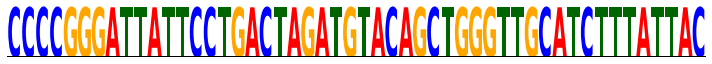

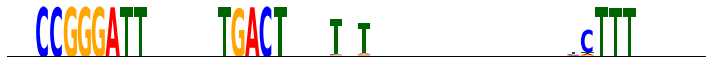

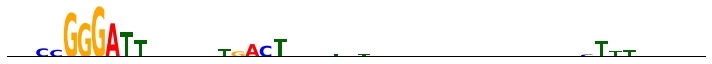

Test sequence 3:
 - Prediction (original) = -5.3
 - Predictions (scrambled) = [-0.4, -1.5, -3.7, -2.5, -5.2, 2.35, 2.91, -2.0, -0.1, 1.84, -1.4, -5.5, -1.9, -0.1, -3.2, -4.0, 3.73, -0.2, -3.2, 0.61, -4.8, -0.6, 4.31, -1.9, 0.27, -0.4, -2.3, 3.41, -0.2, -0.3, 0.74, -6.5]
 - Pred scrambled mean(std):  -0.9915625000000001 2.690339324991134
['AACA', 'CCTA', 'CGGA']
['GAAG', 'CCGC', 'CATT']


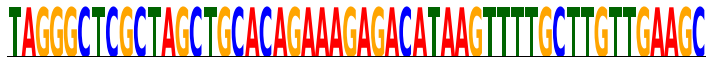

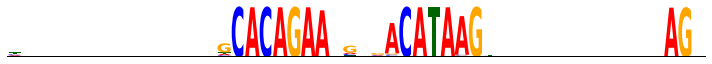

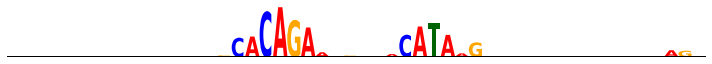

Test sequence 4:
 - Prediction (original) = -5.7
 - Predictions (scrambled) = [-4.6, -6.9, -6.4, -5.5, -6.6, -9.0, -7.0, -10.0, -5.9, -6.1, -7.2, -10.0, -5.8, -6.1, -8.4, -6.0, -7.3, -5.8, -5.5, -8.6, -5.0, -3.4, -6.7, -4.7, -10.0, -5.5, -8.0, -7.1, -7.7, -6.0, -5.7, -6.1]
 - Pred scrambled mean(std):  -6.70625 1.580928821136486
['AACA', 'CCTA', 'CGGA']
['GAAG', 'CCGC', 'CATT']


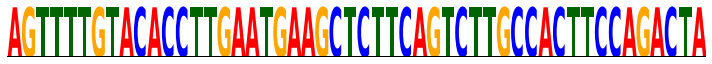

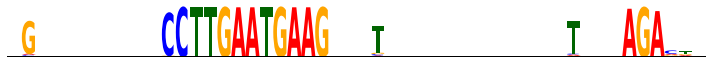

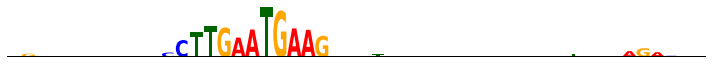

In [65]:
#Visualize a few reconstructed sequence patterns
model_name = 'dummy logic model'
plot_examples = np.arange(5).tolist()
save_examples = []

importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    #print (x_test[test_ix:test_ix+1, ...])
    #print ()
    y_test_hat_ref = predictor_now.predict(x=[x_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor_now.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    pred_values = [float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]
    print (' - Pred scrambled mean(std): ', np.mean(pred_values), np.std(pred_values))
    print (up_motifs)
    print (down_motifs)
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
    plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(10, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
    